<h1><center> CREDIT RISK ANALYSIS </center></h1> 
<h3><center>The main goal of this project is to assist a credit institution in identifying customers that are likely to default, by developing a Probability of Default model.</center></h3>
<h5><center> Francisco Ramalho </center></h5> 
<h5><center> October 2020 </center></h5> 

### Introdution

The objective of this notebook is to build a Deep Learning model that can generate predictions on a very common and complex real-world problem that is Credit Risk Analysis.

The purpose of this project is to predict the risk of a given customer to enter in default, when applying for a loan. We have decided to address this problem by building a binary classification model of Artifincial Neural Network (ANN) to predict whether or not a customer will default on its loan, using the dataset Credit Risk Analysis from Kaggle (link below), which contains customer personal data and customer financial data. The goal of this model is to correctly predict the outcome of the target variable, the customer default status: 0 – not defaulted, 1 – defaulted.

The main goal of this project is to assist a credit institution in identifying customers that are likely to default, by developing a Probability of Default model.

--------------------

### Evaluation Measures
Model assessment should be measured by its Accuracy and Recall. We included the Recall as an evaluation metric because we considered very important to find a model with a high number of true positives and a low number of false negatives, in order to ensure a minimum number of loans incorrectly predicted as non-default. As a benchmark for performance comparison, we considered the model proposed by Karan Agarwal on Kaggle.

--------------------

Notes: the entire notebook takes 1 hour to run (GridsearchCV is not using all CPU cores in order to have reproducible results)

All results are comment below respective output cells

-------------------

Original problem and dataset: https://www.kaggle.com/code/karanagarwal/credit-risk-analysis/notebook

<h3 style='color:#5F6A6E' > Index:</h3>

<strong >1.</strong> [Dataset description](#section1) <p>
<strong>2.</strong> [Importing necessary packages](#section2) <p>
<strong>3.</strong> [Importing data](#section3) <p>
<strong>4.</strong> [Data understanding](#section4) <p>
<strong>5.</strong> [Data preparation](#section5)<p>
<strong>6.</strong> [Model: Baseline model](#section6) <p>
<strong>7.</strong> [Evaluation and Error Analysis](#section7) <p>
<strong>8.</strong> [Model 1: Improving baseline model using GridSearchCV](#section8) <p>
<strong>9.</strong> [Model 2: Triming the 1% and 99% percentile and balanced dataset](#section9) <p>
<strong>10.</strong> [Model 3: Considering only the variables 'employ', 'debtinc, 'creddebt'](#section10) <p>
<strong>11.</strong> [Using our best model (Model 1) to predict new clients](#section11) <p> 
<strong>12.</strong> [Conclusions](#section12) <p>   

<a id="section1">
<h1 style='color:#5F6A6E' > 1. Dataset description</h1>

The dataset contains credit details about credit borrowers.<br>
The variables included in this dataset are:<br>
- **age**: Age of Customer.
- **ed**: Eductation level of customer.
- **employ**: Tenure with current employer (in years).
- **address**: Number of years in same address.
- **income**: Customer Income.
- **debtinc**: Debt to income ratio.
- **creddebt**: Credit to Debt ratio.   
- **othdebt**: Other debts.
- **default**: Customer defaulted in the past (1= defaulted, 0=Never defaulted).

<a id="section2">
<h1 style='color:#5F6A6E' > 2. Importing necessary packages</h1>

In [1]:
import os
import csv
import numpy as np
import datetime as dt
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import category_encoders as ce
import collections

In [2]:
# Fixing a random seed for reproducible results
### Source: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

def resetSeed():
# Seed value
# Apparently you may use different seed values at each stage
    seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)
    # for later versions: 
    # tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
    from keras import backend as K
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


<a id="section3">
<h1 style='color:#5F6A6E' > 3. Importing data</h1>

__Import Dataset__

In [3]:
#Training data
rawdata = pd.read_csv('bankloans.csv', delimiter=',')
data = rawdata.copy(deep=True)

__Visualization Functions__

In [4]:
def display_figures(df, titl, A):
    plt.xticks(rotation='vertical')
    plt.title(titl)   
    show=list(chain(*A))
    i=0
    for p in ax.patches:
        h=p.get_height()
        if (h>0):
            value=show[i]
            ax.text(p.get_x()+p.get_width()/2,h+0.1, value, ha='center')
            i=i+1
            
def corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15,15))

    # Generate a custom diverging colormap
    cmap = 'coolwarm'

    # Draw the heatmap with the mask and correct aspect ratio
    ax=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    bottom, top = ax.get_ylim() 
    ax.set_ylim(bottom + 0.5, top - 0.5) 
            

In [5]:
# Function provided by Professor Nuno Antonio on Machine Learning Course

# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    bottom, top = ax.get_ylim() # These two lines were added due to bug on current Seaborn version
    ax.set_ylim(bottom + 0.5, top - 0.5) #

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [6]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain)]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [7]:
# Function to plot Accuracy/epochs
def PlotAccuracy(loss_train,loss_val,epochs):  
    plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
    plt.title('Accuracy on Training and Validation sets')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
# Function to plot Accuracy/epochs
def PlotLossFunction(loss_train,loss_val,epochs):  
    plt.plot(epochs, loss_train, 'g', label='Training Loss')
    plt.plot(epochs, loss_val, 'b', label='Validation Loss')
    plt.title('Loss on Training and Validation sets')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def RocCurve(FP,TP,thresholds):
    plt.plot(FP,TP,label="ROC")
    plt.xlabel("False Positive Rate  \n(probability of false alarm)")
    plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
    cutoff=np.argmax(np.abs(TP-FP)) 
    optimal_threshold = thresholds[cutoff]
    plt.show()
    print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
    print("Optimal threshold:{0:.3f}".format(optimal_threshold))

<a id="section4">
<h1 style='color:#5F6A6E' > 4. Data understanding</h1>

__First Data Collection Report__

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


In [11]:
data.head(10)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
5,41,2,5,5,25,10.2,0.392700,2.157300,0.0
6,39,1,20,9,67,30.6,3.833874,16.668126,0.0
7,43,1,12,11,38,3.6,0.128592,1.239408,0.0
8,24,1,3,4,19,24.4,1.358348,3.277652,1.0
9,36,1,0,13,25,19.7,2.777700,2.147300,0.0


__Independent variables:__ age (numeric), ed (categorical), employ (numeric), address (numeric), income (numeric), debtinc (numeric), creddebt (numeric), othdebt (numeric) <br>
__Dependent variable__: default (binary)

__First data description report: get more information about the features of our dataset and start identifying strange min-max or mean values, deviations between mean and median.__

In [12]:
summary=data.describe(include="all")
summary=summary.transpose()
summary.rename(columns={'50%':'Median (50%)'}, inplace=True)
summary.head(len(summary))

,count,mean,std,min,25%,Median (50%),75%,max
age,1150.0,35.235652,8.089961,20.000000,29.000000,35.000000,41.00000,56.00000
ed,1150.0,1.695652,0.927051,1.000000,1.000000,1.000000,2.00000,5.00000
employ,1150.0,8.781739,6.914762,0.000000,3.000000,7.000000,13.00000,33.00000
address,1150.0,8.485217,6.977725,0.000000,3.000000,7.000000,12.00000,34.00000
income,1150.0,47.982609,40.508814,13.000000,24.000000,36.000000,56.75000,446.00000
debtinc,1150.0,10.063391,6.584288,0.100000,5.200000,8.750000,13.60000,41.30000
creddebt,1150.0,1.605111,2.135967,0.011696,0.415584,0.899130,1.89882,20.56131
othdebt,1150.0,3.103844,3.529273,0.045584,1.047996,2.038053,3.86496,35.19750
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.00000,1.00000


__Univariate EDA__

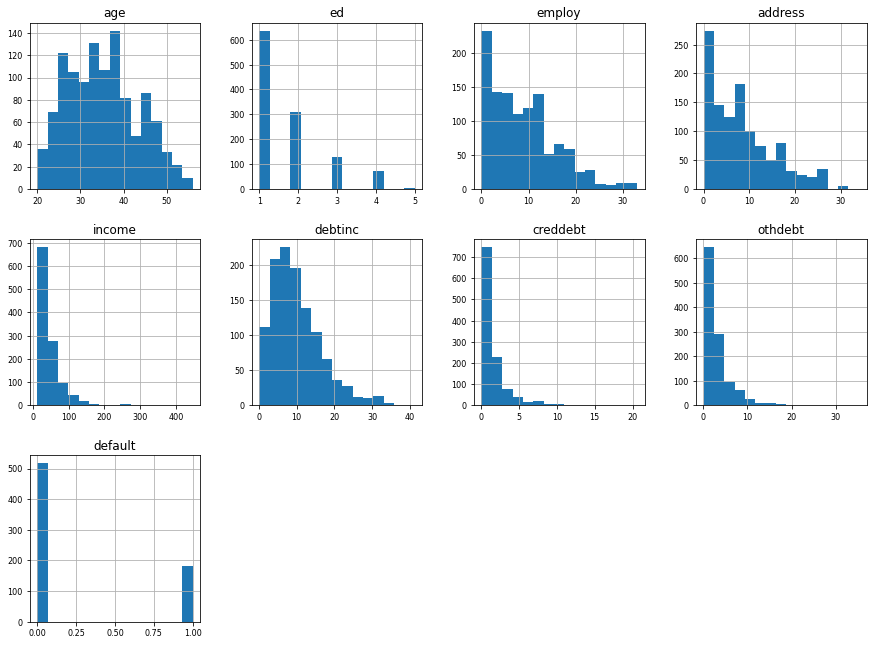

In [13]:
numeric_feat = data.select_dtypes(include=['float64', 'int64'])
numerical = numeric_feat.columns.tolist()
data[numerical].hist(bins=15, figsize=(15,15), layout=(4,4), xlabelsize=8, ylabelsize=8);

The summary table does present consistency in the values of the dataset. It is possible to observe that there are 450 observations with missing values on variable ‘default’. <br>
These observations correspond to new customers to whom the bank aims to evaluate the possibility of providing a loan. We will build our model with the existing customers only, so our dataset will have 700 observations. <br>
The new customers will be considered to run our model and present predictions to the bank regarding their risk of default. <br>
Apart from these 450 observations, there is no evidence of variables with significant outliers that needed to be removed. 

__Bivariate EDA on Numerical Variables__

C:\Users\Francisco\AppData\Local\Temp\ipykernel_12024\941207847.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


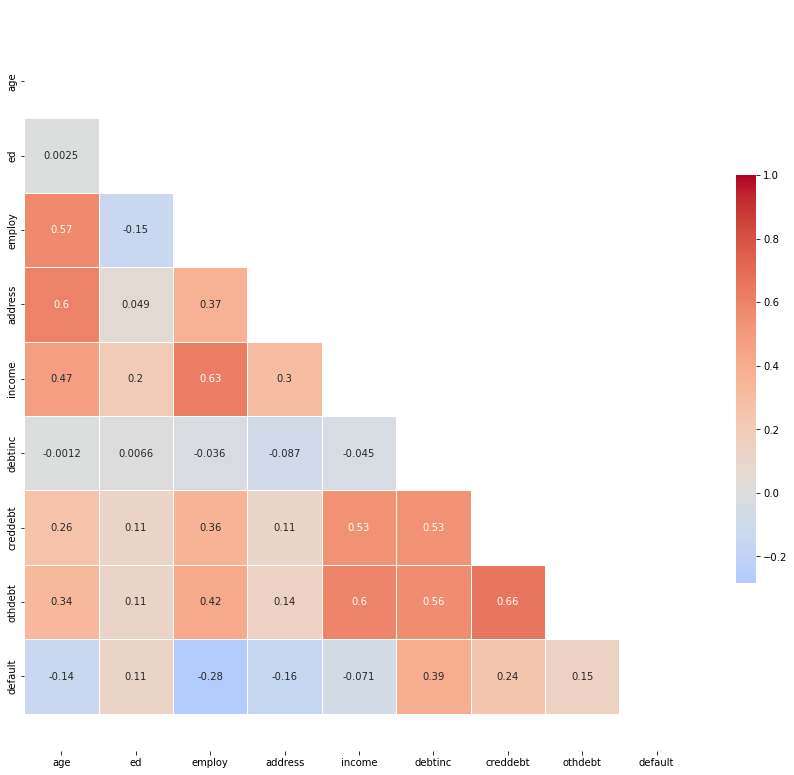

In [14]:
corr_plot(data.corr())

There is a evident correlation between default and __employ__, __address__ and __debtinc__.

From the previous two figures we can conclude that customers with higher debt ratios (__debtinc__, __creddebt__ and __othdebt__), especially Debt to Income Ratio (__debtinc__), have defaulted more than clients with lower debt ratios. <br>
We can also notice that customers with higher tenure in the same employer (__employ__) have defaulted less than the ones with lower tenures. <br>
It is interesting to notice the positive correlation between the variables: __age__, __income__, and __employ__. This suggests that older customers, with longer relationships with their employers have higher income, possibly due to promotions to better positions within their companies. <br>
There is also a small correlation between __income__ and __address__, which may suggest that customers with higher income tend to buy houses instead of renting, resulting in living more years in the same address. <br>
Another point that supports this thesis is the slightly negative correlation between __address__ and __debtinc__. 

<a id="section5">
<h3 style='color:#5F6A6E' > 5. Data Preparation</h3>

In [15]:
DatasetPreparation = data.copy(deep=True)

__Missing Values Identification__

In [16]:
print(DatasetPreparation.isnull().sum())

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     450
dtype: int64


There are missing values in the dependent variable __default__. These missing variables correspond to the new customers to whom we aim to evaluate if we should provide loans or not. 

In [17]:
bankloans_existing = data[data.default.isnull()==0]
bankloans_new = data[data.default.isnull()==1]

We will build our model with existing clients only.

In [18]:
DatasetPreparation2 = bankloans_existing.copy(deep=True)

In [19]:
summary=DatasetPreparation2.describe(include="all")
summary=summary.transpose()
summary.rename(columns={'50%':'Median (50%)'}, inplace=True)
summary.head(len(summary))

,count,mean,std,min,25%,Median (50%),75%,max
age,700.0,34.860000,7.997342,20.000000,29.000000,34.000000,40.000000,56.00000
ed,700.0,1.722857,0.928206,1.000000,1.000000,1.000000,2.000000,5.00000
employ,700.0,8.388571,6.658039,0.000000,3.000000,7.000000,12.000000,31.00000
address,700.0,8.278571,6.824877,0.000000,3.000000,7.000000,12.000000,34.00000
income,700.0,45.601429,36.814226,14.000000,24.000000,34.000000,55.000000,446.00000
debtinc,700.0,10.260571,6.827234,0.400000,5.000000,8.600000,14.125000,41.30000
creddebt,700.0,1.553553,2.117197,0.011696,0.369059,0.854869,1.901955,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,1.044178,1.987567,3.923065,27.03360
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.000000,1.00000


C:\Users\Francisco\AppData\Local\Temp\ipykernel_12024\941207847.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


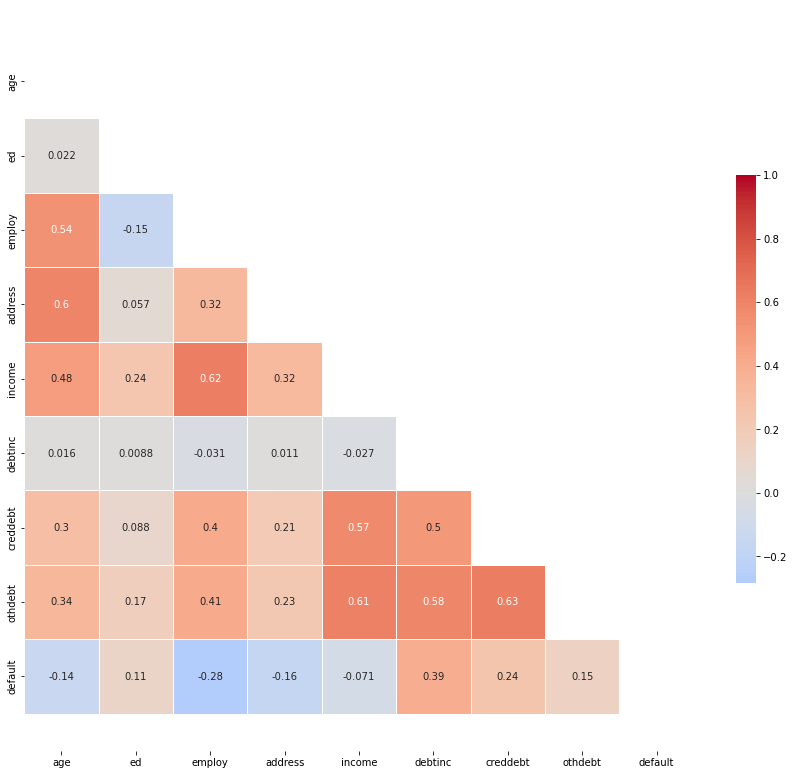

In [20]:
corr_plot(DatasetPreparation2.corr());

There is a evident correlation between default and __employ__, __address__ and __income__.

__Impact of Independent Variables on Dependent Variable__

In [21]:
numeric_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(data.dtypes) if dict(data.dtypes)[key] in ['object']]

In [22]:
numeric_var_names

['age',
 'ed',
 'employ',
 'address',
 'income',
 'debtinc',
 'creddebt',
 'othdebt',
 'default']

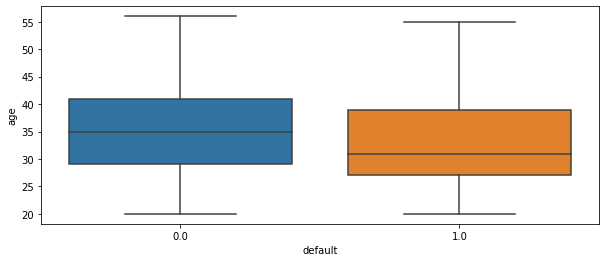

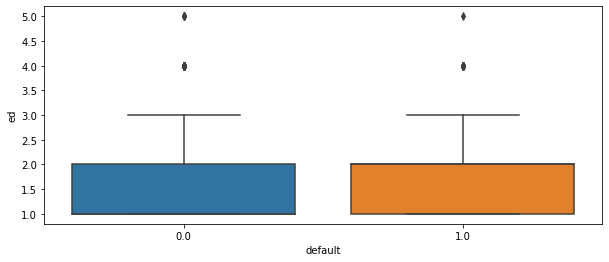

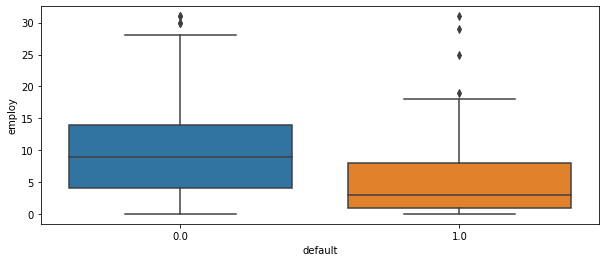

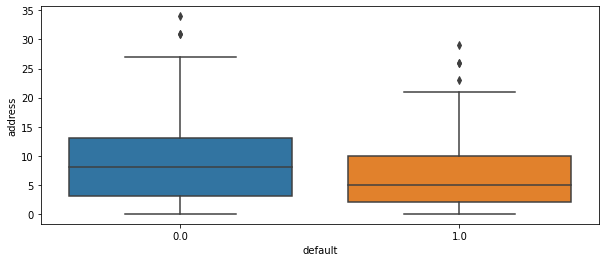

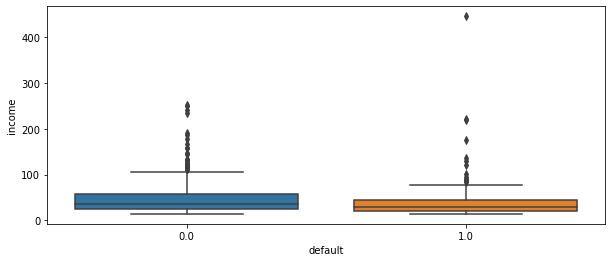

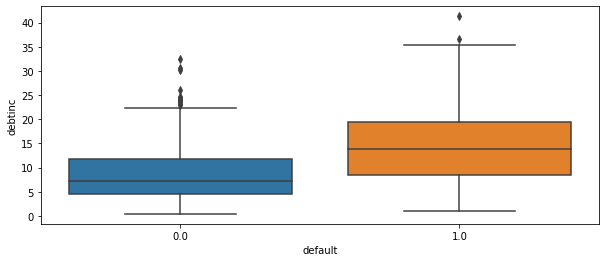

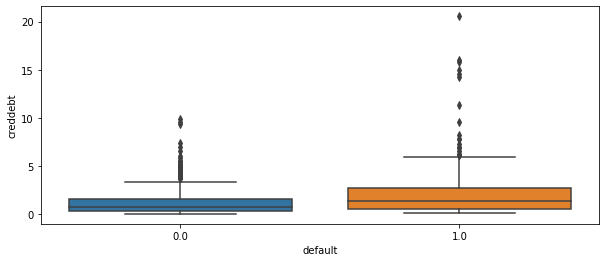

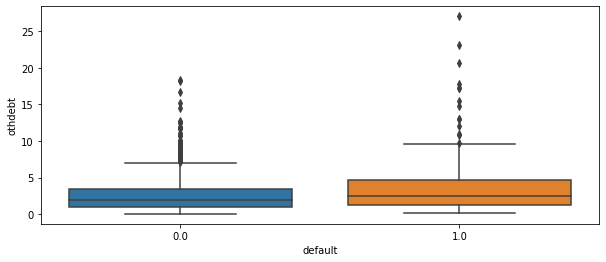

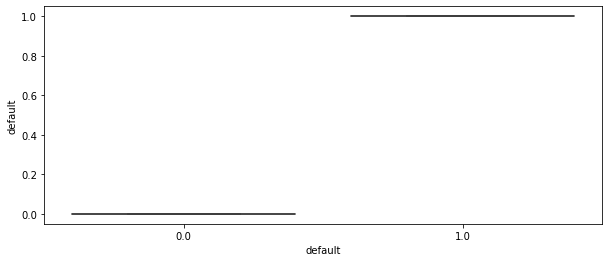

In [23]:
# Visualization from Karan Agarwal (https://www.kaggle.com/karanagarwal/credit-risk-analysis)

from matplotlib.backends.backend_pdf import PdfPages
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = DatasetPreparation2)
    bp.savefig(fig)
bp.close()

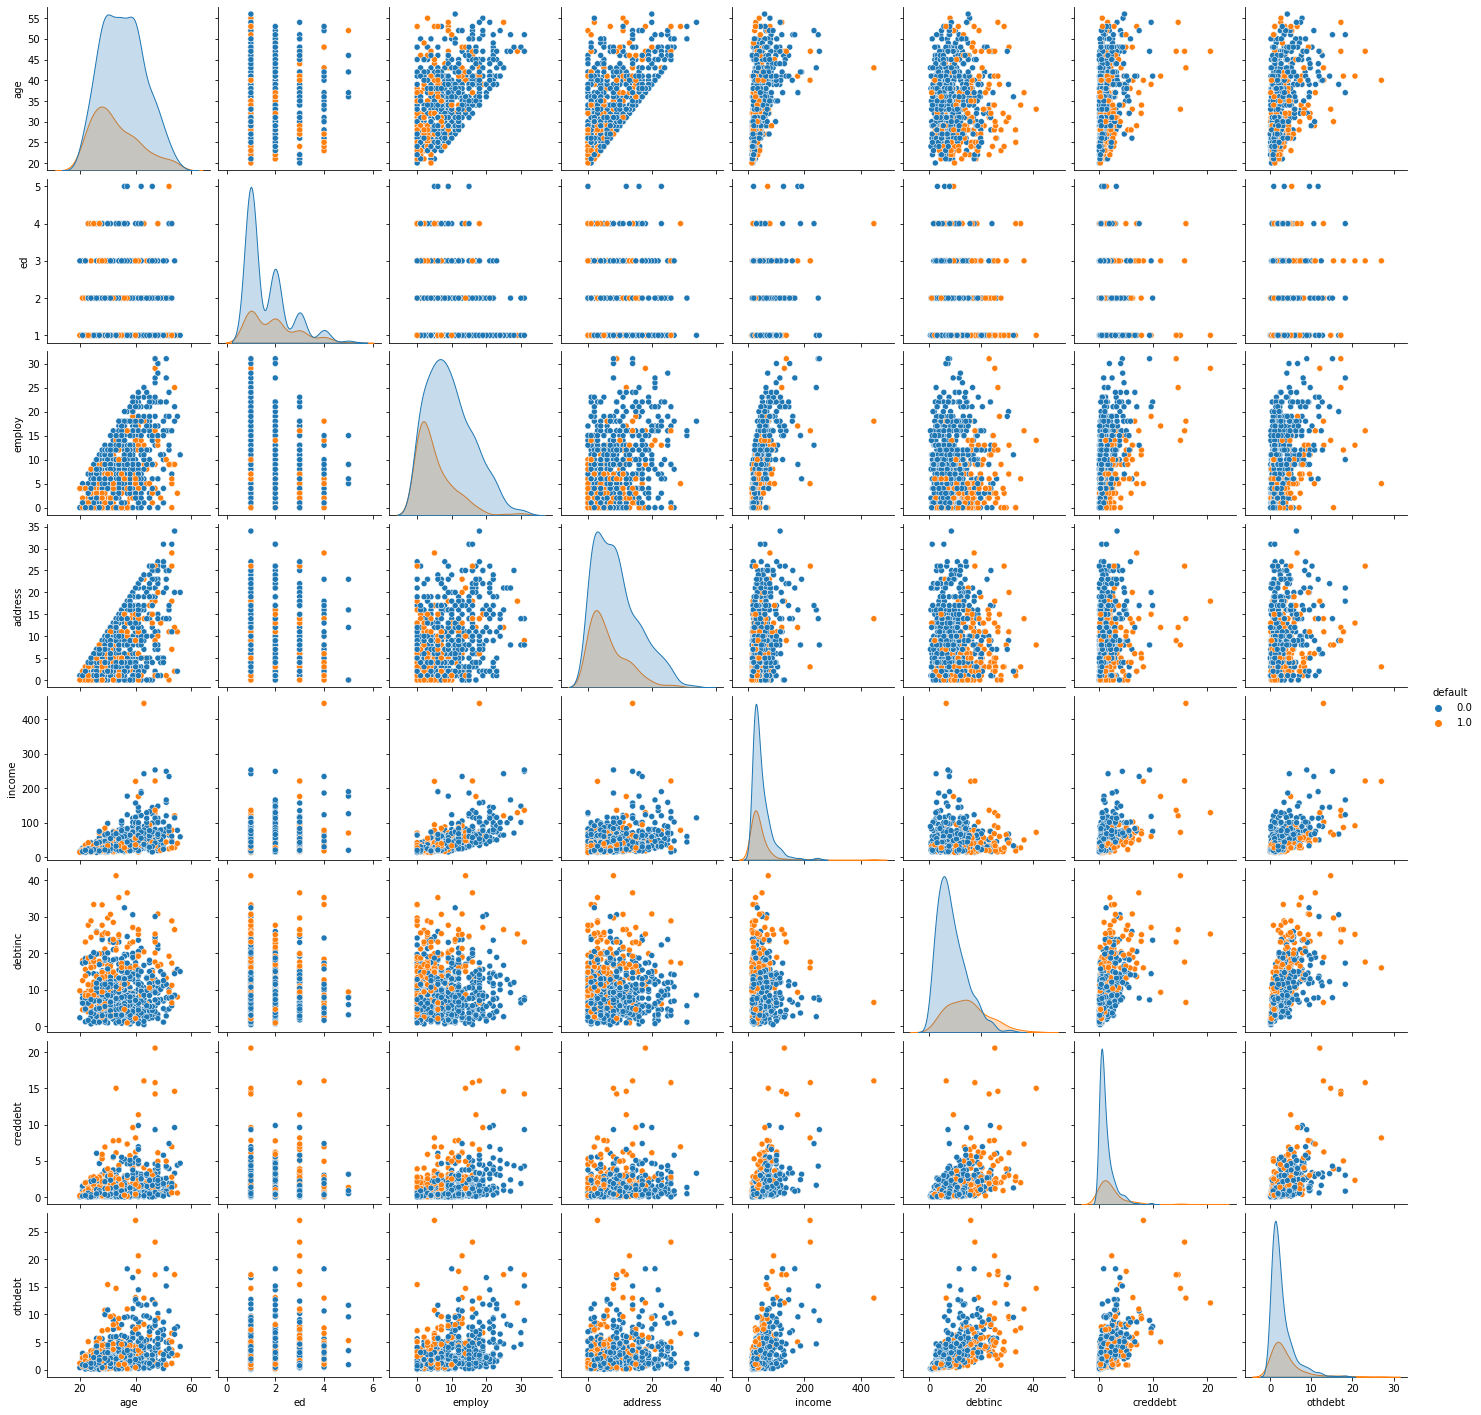

In [24]:
sns.pairplot(data=DatasetPreparation2, hue='default', vars= ['age','ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt'])

In [25]:
DatasetPreparation2.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


Analysing our dataset, there seems it does not appear to have any significant outlier. Given the fact that there are no odd observations and Neural Networks can handle outliers, we will not exclude any observation.

However Education has numerical values, it is in fact a categorical variables

Lets encode variable 'ed'

In [26]:
DatasetPreparation2.value_counts(DatasetPreparation2['ed'])

ed
1    372
2    198
3     87
4     38
5      5
dtype: int64

In [27]:
cols = ['ed']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
DatasetPreparation3 = ce_one_hot.fit_transform(DatasetPreparation2)

C:\Users\Francisco\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [28]:
DatasetPreparation3.head()

,age,ed_3.0,ed_1.0,ed_2.0,ed_4.0,ed_5.0,employ,address,income,debtinc,creddebt,othdebt,default
0,41,1,0,0,0,0,17,12,176,9.3,11.359392,5.008608,1.0
1,27,0,1,0,0,0,10,6,31,17.3,1.362202,4.000798,0.0
2,40,0,1,0,0,0,15,14,55,5.5,0.856075,2.168925,0.0
3,41,0,1,0,0,0,15,14,120,2.9,2.658720,0.821280,0.0
4,24,0,0,1,0,0,2,0,28,17.3,1.787436,3.056564,1.0


In [29]:
CheckDuplicates = DatasetPreparation3[DatasetPreparation3.duplicated()]
CheckDuplicates

,age,ed_3.0,ed_1.0,ed_2.0,ed_4.0,ed_5.0,employ,address,income,debtinc,creddebt,othdebt,default


There is no duplicated values in our dataset.

All variables seems to have valuable information and there is no information overlap between variables (theres is no column calculated based on the others).

We will use all variables to train our model.

In [30]:
X=DatasetPreparation3.iloc[:,0:12].values
y=DatasetPreparation3.iloc[:,12].values

Checking the dataset imbalance on independent variable

Counter({0.0: 517, 1.0: 183})


<AxesSubplot:xlabel='y', ylabel='count'>

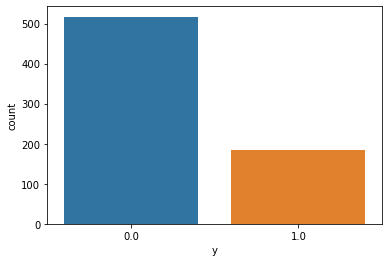

In [31]:
print(collections.Counter(y))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y}))

The dataset does not appear to be significantly imbalance to the point we need to do any oversampling technique

<a id="section6">
<h1 style='color:#5F6A6E' > 6. Baseline </h1>

The dataset considered to build the model was the 700 observations, divided into training set (70%) and testing set (30%). <br>
For training the model we used a validation set which is 20% of the training set. 


In [32]:
#Create training and test sets
#Train=70% (validation set will be 20% of the train set)
#Test=30%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y, random_state=1)

In [33]:
# Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

The Baseline model has 3 dense layers with 6-6-1 nodes. <br>
For the first two layers we used the Rectified Linear Unit Function (‘relu’) for the activation function. On the final layer, we used Sigmoid Function, so the model outputs have a probability between 0 and 1. <br>
As this is a two-class classification problem we used ‘binary_crossentropy’ as the loss function. Moreover, we considered optimizer ‘adam’ and 100 epochs.

In [34]:
resetSeed()

In [35]:
# Construction of the DL model
import keras
#from keras.model import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense
# Create an empty model
classifier=Sequential()

# Adding the first hidden layer (we will choose 6 neurons. We have 12 independent variables after enconding + 1 final node (binary classification problem) = 13 / 2 = 6.5 ~ 6)
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=12))

# Adding a second layer
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Adding the last (output) layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist=classifier.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=0)

# Use the model on unseen data
y_pred=classifier.predict(X_test)
y_pred=(y_pred>0.5)

# Use the model on train data
y_pred_train=classifier.predict(X_train)
y_pred_train=(y_pred_train>0.5)


<a id="section7">
<h1 style='color:#5F6A6E' > 7. Evaluation and Error Analysis</h1>

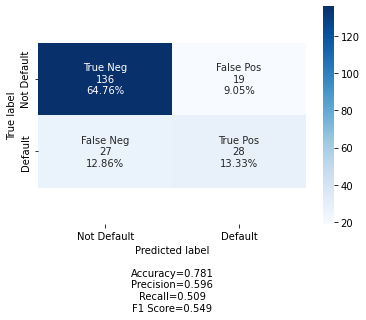

In [36]:
# Confusion Matrix on Test data
cf = metrics.confusion_matrix(y_test,y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Default', 'Default']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [37]:
performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred)

,Measure,Train,Test
0,ACCURACY,0.810204,0.780952
1,PRECISION,0.692308,0.595745
2,RECALL,0.492188,0.509091


In [38]:
#	Measure	    Train	    Test
#0	ACCURACY	0.810204	0.780952
#1	PRECISION	0.692308	0.595745
#2	RECALL	    0.492188	0.509091

In [39]:
def RocCurve(FP,TP,thresholds):
    plt.plot(FP,TP,label="ROC")
    plt.xlabel("False Positive Rate  \n(probability of false alarm)")
    plt.ylabel("True Positive Rate/Sensitivity/Recall \n(probability of detection)")
    cutoff=np.argmax(np.abs(TP-FP)) 
    optimal_threshold = thresholds[cutoff]
    plt.show()
    print("AUC:{0:.3f}".format(metrics.auc(FP, TP)))
    print("Optimal threshold:{0:.3f}".format(optimal_threshold))

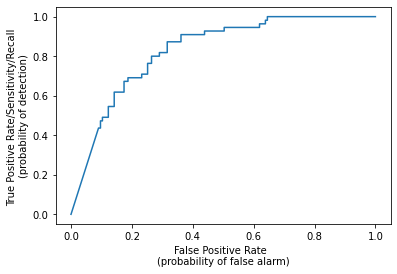

AUC:0.830
Optimal threshold:0.305


In [40]:
# ROC curve
probs = classifier.predict(X_test)
FP,TP,thresholds = metrics.roc_curve(y_test,probs)
RocCurve(FP,TP,thresholds)

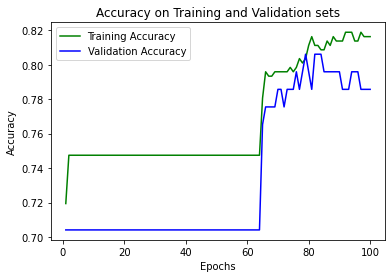

In [41]:
# Visualizing the plots of the loss and accuracy
loss_train=hist.history['accuracy']
loss_val=hist.history['val_accuracy']
epochs=range(1,101)
PlotAccuracy(loss_train,loss_val,epochs)

In [42]:
hist.history['accuracy'][-1]

0.8163265585899353

In [43]:
#0.8163265585899353

In [44]:
hist.history['val_accuracy'][-1]

0.7857142686843872

In [45]:
#0.7857142686843872

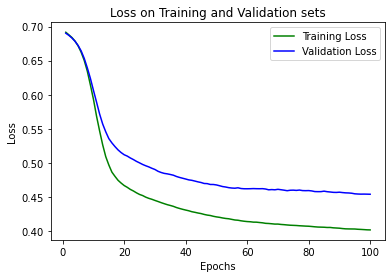

In [46]:
loss_train=hist.history['loss']
loss_val=hist.history['val_loss']
epochs=range(1,101)
PlotLossFunction(loss_train,loss_val,epochs)

Our baseline model scored a 78% Accuracy, 51% Recall and an AUC of 0.83 on the test set.

The number of epoch used was 100, however the model did not improve much after 40 epochs.

Comparing the accuracy, precision and recall on the train and test sets, we can onclude that the model is not overfitting.

Analyzing the evolution of the loss function through epochs, we can see that both lines (training and validation) are decreasing in a continuous and smooth manner, this suggests that if the model had more epochs to train, it would probably learn more about the dataset. <br>
However, lower values of the loss function do not translate directly to better model accuracy, as we observe that the model has slightly better accuracy at around 80 epochs.

Lets try to improve the model by tunning the hyper parameters using gridsearch.

<a id="section8">
<h1 style='color:#5F6A6E' > 8. Model 1: Improving baseline model using GridSearchCV </h1>

Hyperparameters to test:

Hidden Layers: 1,3,6 <br>
Neurons per layer: 6,9,12 <br>
Batch size: 25, 50 <br>
Epochs: 100, 200, 300 <br>
Optimizer algorithm: ‘adam’, ‘rmsprop’

We will use a 5 k-fold stratified cross-validation and evaluate based on the mean accuracy across all folds. Despite our dataset being small, testing 
all combinations of the above parameters can easily become computationally expensive. In order to minimize the computation time, we added a callback that stops training the model if the loss function does not improve in 10 epochs

In [47]:
resetSeed()

In [48]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
import keras
def build_classifier(optimizer,hidden_layers,neurons):
    classifier=Sequential()
    classifier.add(Dense(units=neurons, kernel_initializer='uniform', activation='relu', input_dim=12))
    for i in range(hidden_layers):
        classifier.add(Dense(units=neurons, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_classifier)
cross_validation = StratifiedKFold(n_splits=5, random_state=2, shuffle=True)
callbacks_list=[
    keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,verbose=1)
]
parameters = {'hidden_layers': [1,3,6],
             'neurons': [6,9,12],      # max = 12 neurons = 12 variables
             'batch_size': [25,50],
             'epochs': [100,200,300],
             'optimizer':['adam','rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv=cross_validation, n_jobs=1)

# n_jobs=1 for reproducible results
# n_jobs=-1 for all cpu usage

In [49]:
%%time
resetSeed()
grid_search = grid_search.fit(X_train, y_train,verbose=0,callbacks=callbacks_list)

best_parameters = grid_search.best_params_

best_accuracy = grid_search.best_score_

Epoch 00068: early stopping
Epoch 00068: early stopping
Epoch 00061: early stopping
Epoch 00097: early stopping
Epoch 00061: early stopping
Epoch 00060: early stopping
Epoch 00068: early stopping
Epoch 00192: early stopping
Epoch 00174: early stopping
Epoch 00185: early stopping
Epoch 00077: early stopping
Epoch 00088: early stopping
Epoch 00068: early stopping
Epoch 00164: early stopping
Epoch 00026: early stopping
Epoch 00193: early stopping
Epoch 00172: early stopping
Epoch 00179: early stopping
Epoch 00140: early stopping
Epoch 00040: early stopping
Epoch 00164: early stopping
Epoch 00160: early stopping
Epoch 00193: early stopping
Epoch 00159: early stopping
Epoch 00179: early stopping
Epoch 00185: early stopping
Epoch 00261: early stopping
Epoch 00268: early stopping
Epoch 00073: early stopping
Epoch 00260: early stopping
Epoch 00283: early stopping
Epoch 00268: early stopping
Epoch 00179: early stopping
Epoch 00229: early stopping
Epoch 00223: early stopping
Epoch 00192: early s

In [50]:
best_parameters

{'batch_size': 25,
 'epochs': 100,
 'hidden_layers': 1,
 'neurons': 6,
 'optimizer': 'rmsprop'}

In [51]:
#{'batch_size': 25,
# 'epochs': 100,
# 'hidden_layers': 1,
# 'neurons': 6,
# 'optimizer': 'rmsprop'}

In [52]:
#best accuracy on validation set (mean across 5 fold)
best_accuracy 

0.8040816326530612

In [53]:
#0.8040816326530612

In [54]:
resetSeed()

In [55]:
# Construction of the DL model
import keras
#from keras.model import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense
# Create an empty model
classifier_2=Sequential()

# Adding the first hidden layer (we will choose 6 neurons. We have 12 independent variables after enconding + 1 final node (binary classification problem) = 13 / 2 = 6.5 ~ 6)
classifier_2.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_dim=12))

# Adding a second layer
classifier_2.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

# Adding the last (output) layer
classifier_2.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
hist_2=classifier_2.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=25, verbose=0)

# Use the model on unseen data
y_pred_2=classifier_2.predict(X_test)
y_pred_2=(y_pred_2>0.5)

# Use the model on train data
y_pred_train_2=classifier_2.predict(X_train)
y_pred_train_2=(y_pred_train_2>0.5)


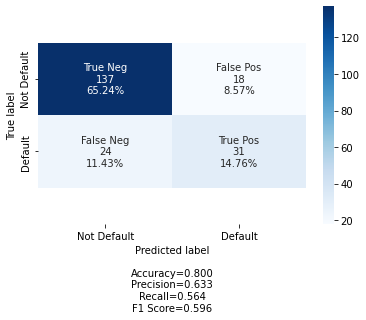

In [56]:
cf = metrics.confusion_matrix(y_test,y_pred_2)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [57]:
performanceMetricsDF(metrics, y_train, y_pred_train_2, y_test, y_pred_2)

,Measure,Train,Test
0,ACCURACY,0.824490,0.800000
1,PRECISION,0.710000,0.632653
2,RECALL,0.554688,0.563636


In [58]:
#	Measure	Train	Test
#0	ACCURACY	0.824490	0.800000
#1	PRECISION	0.710000	0.632653
#2	RECALL	    0.554688	0.563636

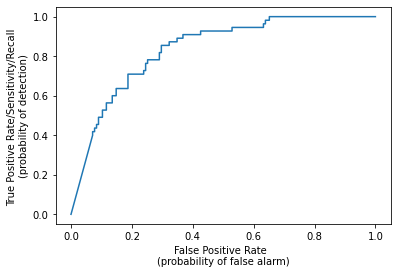

AUC:0.836
Optimal threshold:0.324


In [59]:
# ROC curve
probs = classifier_2.predict(X_test)
FP,TP,thresholds = metrics.roc_curve(y_test,probs)
RocCurve(FP,TP,thresholds)

In [60]:
#AUC:0.836
#Optimal threshold:0.324

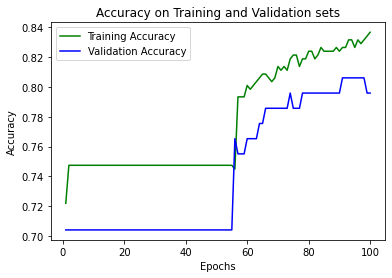

In [61]:
# Visualizing the plots of the loss and accuracy

loss_train=hist_2.history['accuracy']
loss_val=hist_2.history['val_accuracy']
epochs=range(1,101)
PlotAccuracy(loss_train,loss_val,epochs)

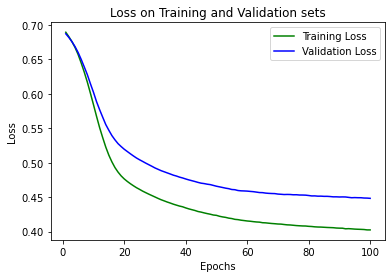

In [62]:
loss_train=hist_2.history['loss']
loss_val=hist_2.history['val_loss']
epochs=range(1,101)
PlotLossFunction(loss_train,loss_val,epochs)

The model with the optimal parameters scored 80% accuracy and 56% recall on the test dataset, with an AUC of 0.836, which translate into an 2% increase in accuracy, 6% recall and 0.06 in AUC. 

<a id="section9">
<h1 style='color:#5F6A6E' > 9. Model 2: Removing  1% and 99% percentiles and balanced dataset</h1>

In our second attempt, we tested removing the highest (99% percentile) and lowest (1% percentile) observations of our dataset. <br>
This reduced our dataset to a total of 640 observations. <br>
Additionally, we decided to balance the dataset by applying the oversampling technique SMOTE (Synthetic Minority Oversampling Technique). This 
oversampling increased the dataset to a total of 670 observations. 


In [63]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

In [64]:
col = ["age", "employ", "address", "income", "debtinc", "creddebt", "othdebt"]
DatasetPreparation4 = removeOutliers(DatasetPreparation3, colList=col, lowPercentile=0.01, highPercentile=0.99, verbose=True)

        age  employ  address  income  debtinc  creddebt    othdebt
0.01  21.00    0.00     0.00    15.0    0.900  0.030209   0.160936
0.99  53.01   27.01    26.01   190.3   30.701  9.891428  17.184744


In [65]:
DatasetPreparation4.describe()

,age,ed_3.0,ed_1.0,ed_2.0,ed_4.0,ed_5.0,employ,address,income,debtinc,creddebt,othdebt,default
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,34.432812,0.120313,0.531250,0.292187,0.048438,0.007812,8.092187,7.987500,42.271875,10.073906,1.347116,2.765675,0.251563
std,7.483640,0.325581,0.499413,0.455124,0.214857,0.088111,6.211399,6.376048,26.446944,6.279631,1.433129,2.538478,0.434250
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.900000,0.030212,0.160983,0.000000
25%,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,24.000000,5.175000,0.373359,1.049471,0.000000
50%,34.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,7.000000,34.000000,8.600000,0.852025,1.945667,0.000000
75%,40.000000,0.000000,1.000000,1.000000,0.000000,0.000000,12.000000,12.000000,52.000000,13.700000,1.801486,3.547740,1.000000
max,53.000000,1.000000,1.000000,1.000000,1.000000,1.000000,27.000000,26.000000,190.000000,30.700000,9.876600,16.668126,1.000000


In [66]:
X3=DatasetPreparation4.iloc[:,0:12].values
y3=DatasetPreparation4.iloc[:,12].values

In [67]:
#Create training and test sets
#Train=70% (validation set will be 20% of the train set)
#Test=30%
from sklearn.model_selection import train_test_split
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3,y3,test_size=0.3,stratify=y3, random_state=1)

In [68]:
# Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_3=sc.fit_transform(X_train_3)
X_test_3=sc.transform(X_test_3)

Counter({0.0: 335, 1.0: 335})


<AxesSubplot:xlabel='y', ylabel='count'>

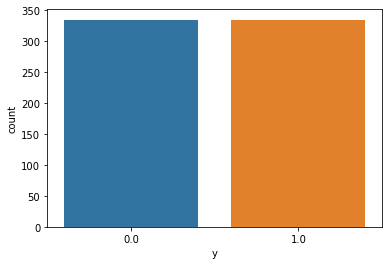

In [69]:
# Import package
from imblearn.over_sampling import SMOTE

# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_3, y_train_3 = sm.fit_resample(X_train_3, y_train_3)

# Display target balance in the training dataset
print(collections.Counter(y_train_3))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train_3}))

In [70]:
%%time
resetSeed()
grid_search_3 = grid_search.fit(X_train_3, y_train_3,callbacks=callbacks_list,verbose=0)

best_parameters = grid_search_3.best_params_

best_accuracy = grid_search_3.best_score_

Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00025: early stopping
Epoch 00029: early stopping
Epoch 00016: early stopping
Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00025: early stopping
Epoch 00020: early stopping
Epoch 00016: early stopping
Epoch 00016: early stopping
Epoch 00025: early stopping
Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00017: early stopping
Epoch 00025: early stopping
Epoch 00029: early stopping
Epoch 00020: early stopping
Epoch 00016: early stopping
Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00017: early stopping
Epoch 00025: early stopping
Epoch 00029: early stopping
Epoch 00020: early stopping
Epoch 00016: early stopping
Epoch 00013: early stopping
Epoch 00018: early s

In [71]:
best_parameters

{'batch_size': 50,
 'epochs': 300,
 'hidden_layers': 1,
 'neurons': 9,
 'optimizer': 'adam'}

In [72]:
#{'batch_size': 50,
# 'epochs': 300,
# 'hidden_layers': 1,
# 'neurons': 9,
# 'optimizer': 'adam'}

In [73]:
best_accuracy

0.8298507462686567

In [74]:
# 0.8298507462686567

In [75]:
resetSeed()

In [76]:
# Construction of the DL model
import keras
#from keras.model import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense
# Create an empty model
classifier_3=Sequential()

# Adding the first hidden layer (we will choose 6 neurons. We have 12 independent variables after enconding + 1 final node (binary classification problem) = 13 / 2 = 6.5 ~ 6)
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu', input_dim=12))

# Adding a second layer
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu'))

# Adding the last (output) layer
classifier_3.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_3=classifier_3.fit(X_train_3, y_train_3, validation_split=0.2, epochs=300,batch_size=50, verbose=0)

# Use the model on unseen data
y_pred_3=classifier_3.predict(X_test_3)
y_pred_3=(y_pred_3>0.5)

# Use the model on train data
y_pred_train_3=classifier_3.predict(X_train_3)
y_pred_train_3=(y_pred_train_3>0.5)


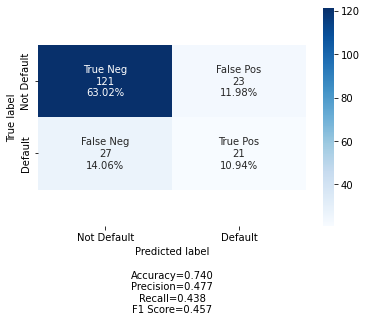

In [77]:
cf = metrics.confusion_matrix(y_test_3, y_pred_3)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [78]:
performanceMetricsDF(metrics, y_train_3, y_pred_train_3, y_test_3, y_pred_3)

,Measure,Train,Test
0,ACCURACY,0.868657,0.739583
1,PRECISION,0.897106,0.477273
2,RECALL,0.832836,0.437500


In [79]:
#Measure	Train	Test
#0	ACCURACY	0.868657	0.739583
#1	PRECISION	0.897106	0.477273
#2	RECALL	    0.832836	0.437500

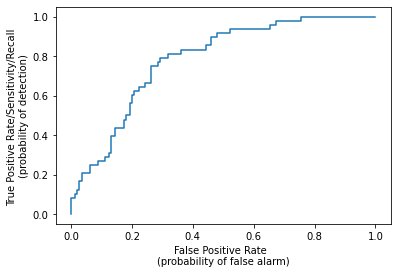

AUC:0.784
Optimal threshold:0.193


In [80]:
# ROC curve
probs = classifier_3.predict(X_test_3)
FP,TP,thresholds = metrics.roc_curve(y_test_3,probs)
RocCurve(FP,TP,thresholds)

In [81]:
# AUC:0.784
# Optimal threshold:0.193

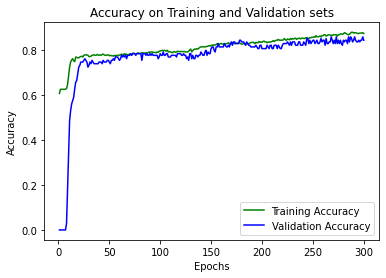

In [82]:
# Visualizing the plots of the loss and accuracy

loss_train=hist_3.history['accuracy']
loss_val=hist_3.history['val_accuracy']
epochs=range(1,301)
PlotAccuracy(loss_train,loss_val,epochs)

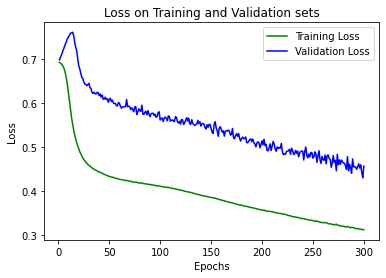

In [83]:
loss_train=hist_3.history['loss']
loss_val=hist_3.history['val_loss']
epochs=range(1,301)
PlotLossFunction(loss_train,loss_val,epochs)

As the model is overfitting we will add L1 and L2 regularization.

In [84]:
resetSeed()
from keras import regularizers
regul=regularizers.l1_l2(l1=0.001, l2=0.001)


# Create an empty model
classifier_3=Sequential()

# Adding the first hidden layer (we will choose 6 neurons. We have 12 independent variables after enconding + 1 final node (binary classification problem) = 13 / 2 = 6.5 ~ 6)
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu', input_dim=12, kernel_regularizer=regul))

# Adding a second layer
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu',kernel_regularizer=regul))

# Adding the last (output) layer
classifier_3.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_3=classifier_3.fit(X_train_3, y_train_3, validation_split=0.2, epochs=300,batch_size=50, verbose=0)

# Use the model on unseen data
y_pred_3=classifier_3.predict(X_test_3)
y_pred_3=(y_pred_3>0.5)

# Use the model on train data
y_pred_train_3=classifier_3.predict(X_train_3)
y_pred_train_3=(y_pred_train_3>0.5)

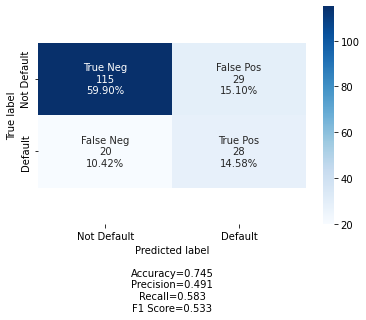

In [85]:
cf = metrics.confusion_matrix(y_test_3, y_pred_3)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [86]:
performanceMetricsDF(metrics, y_train_3, y_pred_train_3, y_test_3, y_pred_3)

,Measure,Train,Test
0,ACCURACY,0.773134,0.744792
1,PRECISION,0.788644,0.491228
2,RECALL,0.746269,0.583333


In [87]:
#   Measure	    Train	    Test
#0	ACCURACY	0.773134	0.744792
#1	PRECISION	0.788644	0.491228
#2	RECALL	    0.746269	0.583333

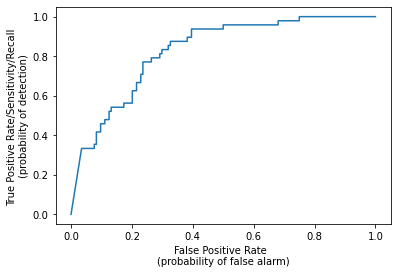

AUC:0.828
Optimal threshold:0.306


In [88]:
# ROC curve
probs = classifier_3.predict(X_test_3)
FP,TP,thresholds = metrics.roc_curve(y_test_3,probs)
RocCurve(FP,TP,thresholds)

In [89]:
# AUC:0.828
# Optimal threshold:0.306

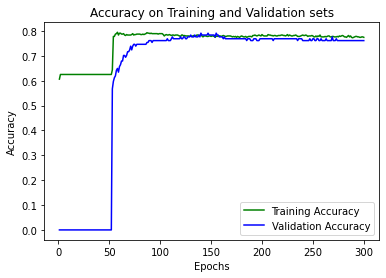

In [90]:
# Visualizing the plots of the loss and accuracy
loss_train=hist_3.history['accuracy']
loss_val=hist_3.history['val_accuracy']
epochs=range(1,301)
PlotAccuracy(loss_train,loss_val,epochs)

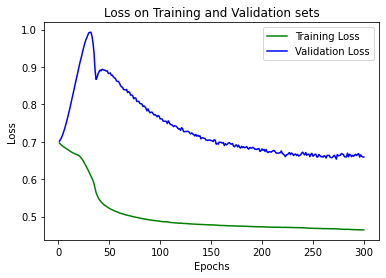

In [91]:
loss_train=hist_3.history['loss']
loss_val=hist_3.history['val_loss']
epochs=range(1,301)
PlotLossFunction(loss_train,loss_val,epochs)

The model is still overfitting specially in precision and recall

Lets add a drop = 0.3

In [92]:
resetSeed()
regul=regularizers.l1_l2(l1=0.001, l2=0.001)
from keras.layers import Dropout
drop_rate=0.15
# Create an empty model
classifier_3=Sequential()

# Adding the first hidden layer (we will choose 6 neurons. We have 12 independent variables after enconding + 1 final node (binary classification problem) = 13 / 2 = 6.5 ~ 6)
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu', input_dim=12, kernel_regularizer=regul))
classifier_3.add(Dropout(drop_rate,seed=8))
# Adding a second layer
classifier_3.add(Dense(units=9, kernel_initializer='uniform', activation='relu',kernel_regularizer=regul))
classifier_3.add(Dropout(drop_rate,seed=8))
# Adding the last (output) layer
classifier_3.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_3=classifier_3.fit(X_train_3, y_train_3, validation_split=0.2, epochs=300,batch_size=50, verbose=0)

# Use the model on unseen data
y_pred_3=classifier_3.predict(X_test_3)
y_pred_3=(y_pred_3>0.5)

# Use the model on train data
y_pred_train_3=classifier_3.predict(X_train_3)
y_pred_train_3=(y_pred_train_3>0.5)

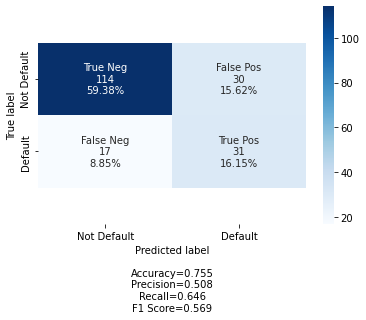

In [93]:
cf = metrics.confusion_matrix(y_test_3, y_pred_3)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [94]:
performanceMetricsDF(metrics, y_train_3, y_pred_train_3, y_test_3, y_pred_3)

,Measure,Train,Test
0,ACCURACY,0.789552,0.755208
1,PRECISION,0.806962,0.508197
2,RECALL,0.761194,0.645833


In [95]:
#    Measure	Train    	Test
#0	ACCURACY	0.789552	0.755208
#1	PRECISION	0.806962	0.508197
#2	RECALL   	0.761194	0.645833

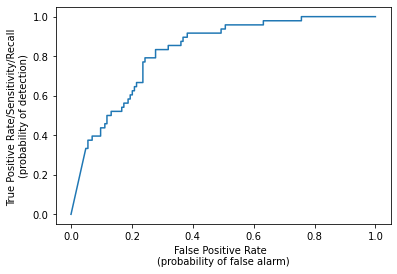

AUC:0.825
Optimal threshold:0.359


In [96]:
# ROC curve
probs = classifier_3.predict(X_test_3)
FP,TP,thresholds = metrics.roc_curve(y_test_3,probs)
RocCurve(FP,TP,thresholds)

In [97]:
# AUC:0.825
# Optimal threshold:0.359

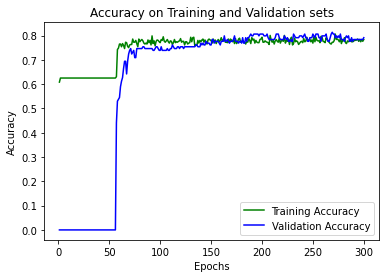

In [98]:
# Visualizing the plots of the loss and accuracy

loss_train=hist_3.history['accuracy']
loss_val=hist_3.history['val_accuracy']
epochs=range(1,301)
PlotAccuracy(loss_train,loss_val,epochs)

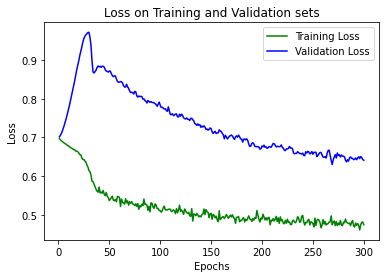

In [99]:
loss_train=hist_3.history['loss']
loss_val=hist_3.history['val_loss']
epochs=range(1,301)
PlotLossFunction(loss_train,loss_val,epochs)

With these two regularization techniques we were able to reduce the model overfitting behavior and achieve more similar results on both the train and test datasets.

The model with the optimal parameters, L1 and L2 regularization and a drop-out of 0.15 scored 76% accuracy and 64% recall on the test dataset, with an AUC of 0.825.

The performance of this model is inferior to Model 1, so we decided to disregard Model 2.



<a id="section10">
<h1 style='color:#5F6A6E' > 10. Model 3: Considering only the variables 'employ', 'debtinc, 'creddebt'</h1>

On our third attempt, we considered only the variables with highest (in absolute value) correlation with the target variable. The variables used to construct this model were __employ__, __debtinc__ and __creddebt__.

To find the optimal parameters we ran a GridSearchCV to tune the following parameters: 
Hidden Layers: 1,3,6 <br>
Neurons per layer: 0,1,2,3 <br>
Batch size: 25, 50 <br>
Epochs: 100, 200, 300 <br>
Optimizer algorithm: ‘adam’, ‘rmsprop’


In [100]:
DatasetPreparation4=DatasetPreparation3[['employ','debtinc','creddebt','default']]
DatasetPreparation4.head(5)

,employ,debtinc,creddebt,default
0,17,9.3,11.359392,1.0
1,10,17.3,1.362202,0.0
2,15,5.5,0.856075,0.0
3,15,2.9,2.658720,0.0
4,2,17.3,1.787436,1.0


In [101]:
X4=DatasetPreparation4.iloc[:,0:3].values
y4=DatasetPreparation4.iloc[:,3].values

In [102]:
#Create training and test sets
#Train=70% (validation set will be 20% of the train set)
#Test=30%
from sklearn.model_selection import train_test_split
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X4,y4,test_size=0.3,stratify=y4, random_state=1)

In [103]:
# Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_4=sc.fit_transform(X_train_4)
X_test_4=sc.transform(X_test_4)

In [104]:
resetSeed()

In [105]:
def build_classifier_4(optimizer,hidden_layers,neurons):
    classifier=Sequential()
    classifier.add(Dense(units=neurons, kernel_initializer='uniform', activation='relu', input_dim=3))
    for i in range(hidden_layers):
        classifier.add(Dense(units=neurons, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier_4 = KerasClassifier(build_fn=build_classifier_4)
cross_validation = StratifiedKFold(n_splits=5, random_state=2, shuffle=True)
callbacks_list=[
    keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,verbose=1)
]
parameters = {'hidden_layers': [0,1,3,6],
             'neurons': [1,2,3],      # max = 3 neurons = 3 variables
             #add call backs if needed
             'batch_size': [25,50],
             'epochs': [100,200,300],
             'optimizer':['adam','rmsprop']}
grid_search_model4 = GridSearchCV(estimator = classifier_4,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv=cross_validation, n_jobs=1)

# n_jobs=1 for reproducible results
# n_jobs=-1 for all cpu usage

In [106]:
%%time
resetSeed()
grid_search_4 = grid_search_model4.fit(X_train_4, y_train_4,callbacks=callbacks_list,verbose=0)

best_parameters = grid_search_4.best_params_

best_accuracy = grid_search_4.best_score_

Epoch 00081: early stopping
Epoch 00088: early stopping
Epoch 00178: early stopping
Epoch 00187: early stopping
Epoch 00171: early stopping
Epoch 00192: early stopping
Epoch 00169: early stopping
Epoch 00178: early stopping
Epoch 00164: early stopping
Epoch 00169: early stopping
Epoch 00104: early stopping
Epoch 00171: early stopping
Epoch 00174: early stopping
Epoch 00169: early stopping
Epoch 00178: early stopping
Epoch 00164: early stopping
Epoch 00174: early stopping
Epoch 00169: early stopping
Epoch 00164: early stopping
Epoch 00044: early stopping
Epoch 00171: early stopping
Epoch 00174: early stopping
Epoch 00108: early stopping
Epoch 00171: early stopping
Epoch 00174: early stopping
Epoch 00169: early stopping
Epoch 00178: early stopping
Epoch 00164: early stopping
Epoch 00171: early stopping
Epoch 00174: early stopping
Epoch 00169: early stopping
Epoch 00178: early stopping
Epoch 00164: early stopping
Epoch 00174: early stopping
Epoch 00241: early stopping
Epoch 00217: early s

In [107]:
best_parameters

{'batch_size': 25,
 'epochs': 100,
 'hidden_layers': 1,
 'neurons': 3,
 'optimizer': 'adam'}

In [108]:
#{'batch_size': 25,
# 'epochs': 100,
# 'hidden_layers': 1,
# 'neurons': 3,
# 'optimizer': 'adam'}

In [109]:
best_accuracy

0.8

In [110]:
# 0.8

In [111]:
resetSeed()

In [112]:
# Construction of the DL model
import keras
#from keras.model import Sequential
from tensorflow.keras import Sequential
from keras.layers import Dense
# Create an empty model
classifier_4=Sequential()

# Adding the first hidden layer
classifier_4.add(Dense(units=3, kernel_initializer='uniform', activation='relu', input_dim=3))

# Adding a second layer
classifier_4.add(Dense(units=3, kernel_initializer='uniform', activation='relu'))

# Adding the last (output) layer
classifier_4.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Training the model
classifier_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist_4=classifier_4.fit(X_train_4, y_train_4, validation_split=0.2, epochs=100, batch_size=25, verbose=0)

# Use the model on unseen data
y_pred_4=classifier_4.predict(X_test_4)
y_pred_4=(y_pred_4>0.5)

# Use the model on train data
y_pred_train_4=classifier_4.predict(X_train_4)
y_pred_train_4=(y_pred_train_4>0.5)


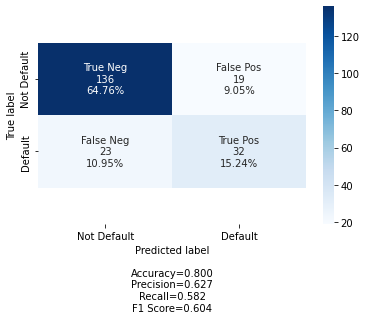

In [113]:
cf = metrics.confusion_matrix(y_test_4, y_pred_4)
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [114]:
performanceMetricsDF(metrics, y_train_4, y_pred_train_4, y_test_4, y_pred_4)

,Measure,Train,Test
0,ACCURACY,0.791837,0.800000
1,PRECISION,0.618182,0.627451
2,RECALL,0.531250,0.581818


In [115]:
#	Measure	     Train	    Test
#0	ACCURACY	0.791837	0.800000
#1	PRECISION	0.618182	0.627451
#2	RECALL	    0.531250	0.581818

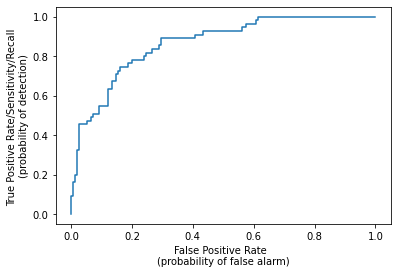

AUC:0.865
Optimal threshold:0.268


In [116]:
# ROC curve
probs = classifier_4.predict(X_test_4)
FP,TP,thresholds = metrics.roc_curve(y_test_4,probs)
RocCurve(FP,TP,thresholds)

In [117]:
#AUC:0.865
#Optimal threshold:0.268

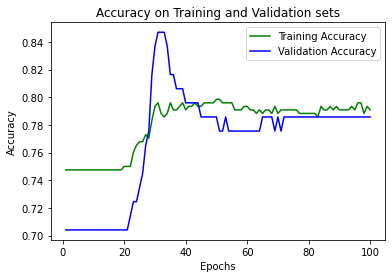

In [118]:
# Visualizing the plots of the loss and accuracy

loss_train=hist_4.history['accuracy']
loss_val=hist_4.history['val_accuracy']
epochs=range(1,101)
PlotAccuracy(loss_train,loss_val,epochs)

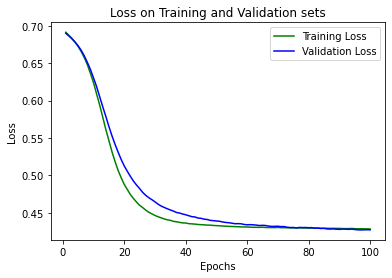

In [119]:
loss_train=hist_4.history['loss']
loss_val=hist_4.history['val_loss']
epochs=range(1,101)
PlotLossFunction(loss_train,loss_val,epochs)

The model with the optimal parameters, scored 80% accuracy and 58% recall on the test dataset, with an AUC of 0.865.

Model 3 revealed surprisingly good results considering the number of variables used to train it. The performance in the test dataset was similar to Model 1, however as the performance on the train dataset was worse, we are more confident with the results of Model 1. 

Nevertheless, Model 3 could be a viable alternative to Model 1 if data usage is a business restriction.


<a id="section11">
<h1 style='color:#5F6A6E' > 11. Using our best model (Model 1) to predict new clients</h1>

Remember that classifier_2 corresponds to Model 1 

In [120]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


In [121]:
bankloans_new2=bankloans_new.drop(['default'], axis=1)
bankloans_new2=ce_one_hot.fit_transform(bankloans_new2)

C:\Users\Francisco\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):


In [122]:
bankloans_new2.head()

,age,ed_1.0,ed_2.0,ed_4.0,ed_3.0,employ,address,income,debtinc,creddebt,othdebt
700,36,1,0,0,0,16,13,32,10.9,0.544128,2.943872
701,50,1,0,0,0,6,27,21,12.9,1.316574,1.392426
702,40,1,0,0,0,9,9,33,17.0,4.880700,0.729300
703,31,1,0,0,0,5,7,23,2.0,0.046000,0.414000
704,29,1,0,0,0,4,0,24,7.8,0.866736,1.005264


In [123]:
#ordenate columns
bankloans_new2['ed_5.0']=0
bankloans_new2 = bankloans_new2[['age',	'ed_3.0', 'ed_1.0',	'ed_2.0','ed_4.0','ed_5.0',	'employ','address',	'income','debtinc','creddebt','othdebt']]
bankloans_new2.head()

,age,ed_3.0,ed_1.0,ed_2.0,ed_4.0,ed_5.0,employ,address,income,debtinc,creddebt,othdebt
700,36,0,1,0,0,0,16,13,32,10.9,0.544128,2.943872
701,50,0,1,0,0,0,6,27,21,12.9,1.316574,1.392426
702,40,0,1,0,0,0,9,9,33,17.0,4.880700,0.729300
703,31,0,1,0,0,0,5,7,23,2.0,0.046000,0.414000
704,29,0,1,0,0,0,4,0,24,7.8,0.866736,1.005264


In [124]:
sc=StandardScaler()
bankloans_new3=sc.fit_transform(bankloans_new2)

In [125]:
bankloans_new_predict=classifier_2.predict(bankloans_new3)
bankloans_new_predict=(bankloans_new_predict>0.5)

In [126]:
np.count_nonzero(bankloans_new_predict == 1)

87

In [127]:
#87

In [128]:
np.count_nonzero(bankloans_new_predict == 0)

363

In [129]:
#363

In [130]:
pd.options.mode.chained_assignment = None
bankloans_new['prediction']=bankloans_new_predict
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prediction
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,False
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,False
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,True
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,False
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,False


<a id="section12">
<h1 style='color:#5F6A6E' > 12. Conclusion</h1>

From the models tested, we concluded that the model with the best performance was Model 1. This model was achieved by tuning the hyperparameters of the baseline model, resulting in a surprisingly similar model. <br>
The differential factor between the two models was the addition of batch size that allowed the network to update its weights based on a small number of samples (50 samples instead of 490).<br>
Comparing Model 1 against the Logistic Regression model presented by Karan Agarwal in Kaggle, we can observe higher performance metrics in the train dataset. <br>
This means that the Neural Network was able to learn more characteristics and deeper patterns of the data using the same number of observations (both models were trained with 490 observations). However, when predicting the test dataset, the Neural Network achieved lower performance.


| Meausre   || Liner Regression <br> Train | Liner Regression <br> Test || Baseline Model <br> Train | Baseline Model <br> Test || Model 3 <br> Train | Model 3 <br> Test |
| :-:       || :-:   | :-:  || :-:   | :-:  || :-:   | :-:  |
| Accuracy  || 79%   | 81%  || 78%   | 78%  || 82%   | 80%  |
| Precision || 67%   | 69%  || 60%   | 60%  || 71%   | 63%  |
| Recall    || 47%   | 61%  || 49%   | 51%  || 55%   | 56%  |



Overall, we consider the Neural Network to be a competent model for our business problem, as it shown good and consistent performance across train and test datasets. <br>
On the other hand, despite the slight impression of underfitting, the Logistic Regression model can be a good option as it is easier to interpret and explain to business professionals. <br>
Using our best model to predict the probability of default of the 450 new customers, we obtained that 87 (19%) will default while 363 (81%) will not. 
We recognize that this model was developed on a small dataset that did not required much data cleaning, which can be a difficult and time-consuming task when dealing with real world data. <br>
A wider dataset could definitively improve the model performance and increase the confidence of the users when applying it to unseen data. 